In [1]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from funcs import regression_system
from funcs import fcnn
from funcs import dataset

In [3]:
BASE = '/ML_project/'
PATH_NN= 'data/'
save_path="models/"
save_name="test-4.pt"

In [ ]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch

submeso_dataset=dataset.SubmesoDataset(['grad_B','FCOR', 'Nsquared', 'HML', 'TAU',
              'Q', 'HBL', 'div', 'vort', 'strain'],res='1_4')

In [ ]:
train_loader=DataLoader(
    submeso_dataset,
    #num_workers=10,
    batch_size=64,
    sampler=SubsetRandomSampler(submeso_dataset.train_ind))

test_loader=DataLoader(
    submeso_dataset,
    #num_workers=10,
    batch_size=len(submeso_dataset.test_ind),
    sampler=submeso_dataset.test_ind)

In [ ]:
#can you put the model into the same format (will to(device) work??)

In [ ]:
device = torch.device('cpu')
#device = torch.device('cuda')

In [9]:
model = torch.load('models/test-4.pt',map_location=device)

In [10]:
#giving normalized units
for x_data, y_data in test_loader:
    prediction = model(x_data.to(device))

# Dataloader

### Create input and output channels

In [11]:
#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)

# 846/14 = 60, 846 length of timeseries in each region, 14 motnhs of data
for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


In [12]:
drF = np.load(PATH_NN+'drF.npy')
WB_sg= np.load(PATH_NN+'WB_sg.npy')
WB_sg_mean = np.load(PATH_NN+'WB_sg_mean.npy')
WB_sg_std = np.load(PATH_NN+'WB_sg_std.npy')

In [13]:
print(WB_sg_mean, WB_sg_std)

5.7102721130731605e-09 1.0793481225977522e-08


In [14]:
# renormalize using mean and std 
# SORT test_ind for timeseries
test_ind = submeso_dataset.test_ind

mean_tile = np.tile(WB_sg_mean,(2030,1,40,40))
std_tile = np.tile(WB_sg_std,(2030,1,40,40))

In [15]:
# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((12,2030,40,40))
drF_test_loc[:] = np.nan

In [16]:
WB_cnn = np.squeeze((model(x_data.to(device)).detach().cpu().numpy()*std_tile + mean_tile))
WB_sg = np.squeeze(xr.DataArray((y_data.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((12,2030,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_mean = np.empty((12,2030))

WB_sg_loc = np.empty((12,2030,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_mean = np.empty((12,2030))

In [17]:
location_month_index_test = location_month_index[test_ind]
location_month_index_loc = np.empty((12,2030))
location_month_index_loc[:] = np.nan

for i_loc in range(12):

    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]

    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5  
    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_mean[i_loc] = (np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2]))/ np.nansum(drF_test_loc[i_loc]))**0.5

    location_month_index_loc[i_loc,location_index[test_ind]==i_loc] = location_month_index_test[location_index[test_ind]==i_loc]


In [18]:
label_list = ['Arabian Sea','New Zealand', 'Agulhas Current', 'Kuroshio Extension', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific','California Current', 'Indian Ocean', ]

month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Snapshots from the Gulf Stream during the month of Mar


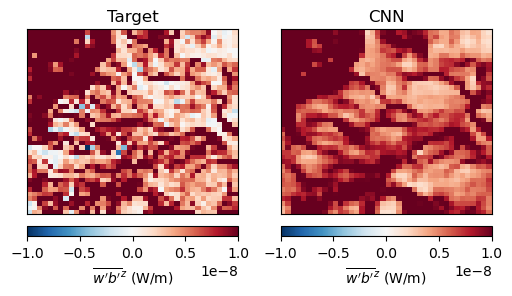

In [32]:
#plot snapshots

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(6,3))
#fig.tight_layout(pad=5.0)

i_loc=6
it = 125
clim = 1e-8

plt.subplot(1,2,1)
plt.pcolor(WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:][it],cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('Target',fontsize=12)

plt.subplot(1,2,2)
plt.pcolor(WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:][it],cmap='RdBu_r',vmin=-clim,vmax=clim)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05)
cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('CNN',fontsize=12)

print('Snapshots from the '+label_list[i_loc]+' during the month of '+month_list[round(location_month_index_test[it])-1])
#plt.savefig('./figures/snapshots')

Obviously something is going wrong here. I'm afraid I'm not familiar enough with this to troubleshoot though...

In [33]:
# compute r2 value across all test dataset

r2_score_cnn = r2_score(WB_sg.values.flatten(),WB_cnn.flatten())
r2_score_cnn

0.8106279830654188

In [ ]:
'''
Steps:
- remove activation function (linear model)
- try lots of different model sizes including
- MLD, buoyancy gradient         (approx physical parametrization)
- MLD, buoyancy gradient, strain (new physical parametrization)
- all 10                         (Abigail's)

In [ ]:
#           strain,vort  ,gradB ,HML   ,all
inputs   = [1     ,2     ,3     ,4     ,10    ]
params   = [133569,136769,139969,143169,162369]
val_loss = [0.444 ,0.3401,0.2793,0.2386,0.2168]
R2       = [      ,]